In [627]:
import b3d
import jax.numpy as jnp
import jax
from b3d import Mesh, Pose
import os
import functools
import genjax
import matplotlib.pyplot as plt
from genjax import Pytree

In [623]:
renderer = b3d.renderer.RendererOriginal()

In [634]:
b3d.rr_init()

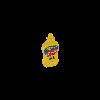

In [625]:
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
id = 4
mesh = Mesh.from_obj_file(
        os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')
    ).scale(0.001)
gt_pose = Pose.from_position_and_target(jnp.array([0.25, 0.25, 0.2])).inv()
observed_rgbd = renderer.render_rgbd_from_mesh(mesh.transform(gt_pose))
b3d.viz_rgb(observed_rgbd)

In [661]:
import b3d.chisight.dense.dense_model
b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.utils)
import b3d.chisight.dense.likelihoods.blur_likelihood
b3d.reload(b3d.chisight.dense.likelihoods.blur_likelihood)
intermediate_likelihood_func = b3d.chisight.dense.likelihoods.blur_likelihood.blur_intermediate_likelihood_func
# blur_intermediate_sample_func = b3d.chisight.dense.likelihoods.blur_likelihood.blur_intermediate_sample_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)
value_and_grad_func = jax.jit(
    jax.value_and_grad(
        lambda trace, pose: b3d.update_choices_get_score(trace, Pytree.const(("object_pose_0",)), pose),
        argnums=1
    )
)

In [670]:
filter_half_width = 4

k = 1000
rows = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        jax.random.split(jax.random.PRNGKey(10), k),
        jnp.ones((k, renderer.height - (filter_half_width * 2 + 1)))) + filter_half_width
cols = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        jax.random.split(jax.random.PRNGKey(11), k),
        jnp.ones((k, renderer.width  - (filter_half_width * 2 + 1)))) + filter_half_width


args = ({
    "num_objects": Pytree.const(1),
    "meshes": [mesh],
    "likelihood_args": {
        "fx": renderer.fx,
        "fy": renderer.fy,
        "cx": renderer.cx,
        "cy": renderer.cy,
        "rows":  rows,
        "cols": cols,
    },
},)

pose = gt_pose
pose = Pose.from_position_and_target(jnp.array([0.3, 0.2, 0.0])).inv()

choicemap = genjax.ChoiceMap.d(
    {
        "camera_pose": Pose.identity(),
        "object_pose_0": pose,
        # "object_pose_0": all_data[T]["object_poses"][0],
        "color_variance_0": 0.05,
        "depth_variance_0": 0.01,
        "outlier_probability_0": 0.01,
        "blur": 1.5,
    }
)
key = jax.random.PRNGKey(10)
trace = importance_jit(key, choicemap, args)[0]
trace = b3d.update_choices(trace, Pytree.const(("rgbd",)), b3d.resize_image_nearest(observed_rgbd, renderer.height, renderer.width))
viz_trace(trace, 0)

In [671]:
# hierachical bayes inference of  "outlier_probability_0", "blur"
outlier_probability_sweep = jnp.linspace(0.01, 0.4, 30)
blur_sweep = jnp.linspace(0.1, 50.0, 30)
addresses= Pytree.const(( "outlier_probability_0", "blur"))
sweeps = [ outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
print(scores.max())
index = jnp.unravel_index(scores.argmax(), scores.shape)

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T

print(sampled_parameters[:5])

trace = b3d.update_choices(trace, addresses, *sampled_parameters[0])
viz_trace(trace,0)

21.777847
[[ 0.4        32.793102  ]
 [ 0.37310344 34.513794  ]
 [ 0.4        48.27931   ]
 [ 0.4        36.234486  ]
 [ 0.4        36.234486  ]]


In [672]:
pbar = tqdm(range(1000))
for _ in pbar:
    loss, grad_pose = value_and_grad_func(trace, trace.get_choices()["object_pose_0"])
    pbar.set_description(f"Loss {loss}")
    trace = b3d.update_choices(trace, Pytree.const(("object_pose_0",)), trace.get_choices()["object_pose_0"] + grad_pose * 0.000001)
viz_trace(trace, 0)


Loss 434.9935607910156: 100%|██████████| 1000/1000 [00:06<00:00, 156.74it/s]


In [597]:
# pose = gt_pose

# filter_half_width = 5
# k = 1000
# rows = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
#         jax.random.split(jax.random.PRNGKey(10), k),
#         jnp.ones((k, renderer.height - (filter_half_width * 2 + 1)))) + filter_half_width
# cols = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
#         jax.random.split(jax.random.PRNGKey(11), k),
#         jnp.ones((k, renderer.width  - (filter_half_width * 2 + 1)))) + filter_half_width


# def render(pose):
#     mesh_transformed = mesh.transform(pose)
#     fx,fy,cx,cy = renderer.fx, renderer.fy, renderer.cx, renderer.cy

#     rasterize_results = renderer.rasterize(mesh_transformed.vertices, mesh_transformed.faces)
#     triangle_collision_indices_image = rasterize_results[..., 3].astype(jnp.int32) - 1
#     valid = triangle_collision_indices_image >= 0

#     far_plane_xyz = b3d.xyz_from_depth(jnp.ones((renderer.height, renderer.width)), fx, fy, cx, cy)
#     vertices_mean_image = (
#         valid[...,None] * mesh_transformed.vertices[mesh_transformed.faces[triangle_collision_indices_image]].mean(axis=-2) +
#         ~valid[...,None] * far_plane_xyz
#     )
#     colors_image = renderer.render_rgbd_from_mesh(mesh_transformed)[..., :3]



#     color_variance = 0.05
#     depth_variance = 0.01

#     sigma = 1.5
#     outlier_probability = 0.01


#     ###########
#     @functools.partial(
#         jnp.vectorize,
#         signature="(m)->()",
#     )
#     def score_pixel(ij):
#         lower_indices = (ij[0] - filter_half_width, ij[1] - filter_half_width, 0)
#         length = (2 * filter_half_width + 1, 2 * filter_half_width + 1, 3)
#         vertices_mean_window = jax.lax.dynamic_slice(
#             vertices_mean_image,
#             lower_indices, length
#         )
#         colors_window = jax.lax.dynamic_slice(
#             colors_image,
#             lower_indices, length
#         )
#         valid_window = jax.lax.dynamic_slice(
#             valid,
#             lower_indices[:2], length[:2]
#         )

#         observed_color = observed_rgbd[ij[0], ij[1], :3]
#         observed_depth = observed_rgbd[ij[0], ij[1], 3]
#         depth_probability = jax.scipy.stats.norm.logpdf(
#             observed_depth,
#             vertices_mean_window[..., 2],
#             depth_variance,
#         )
#         color_probability = jax.scipy.stats.norm.logpdf(
#             observed_color,
#             colors_window,
#             color_variance,
#         )
#         probability = color_probability.sum(-1) + depth_probability
#         # error = jnp.abs(colors_window - observed_color)
#         # inliers = jnp.all(
#         #     error
#         #     < jnp.array(
#         #         [color_variance, color_variance, color_variance]
#         #     ),
#         #     axis=-1,
#         # )

#         scores_inlier = (valid_window * probability)

#         pixel_coordinates = b3d.xyz_to_pixel_coordinates(vertices_mean_window, fx, fy, cx, cy)

#         _log_kernel = (((pixel_coordinates - ij)**2).sum(-1) * -1.0  / (2.0 * sigma**2))
#         log_kernel = _log_kernel - jax.nn.logsumexp(_log_kernel)
#         log_kernel = log_kernel - jax.nn.logsumexp(log_kernel)

#         score_mixed = jax.nn.logsumexp(scores_inlier + log_kernel)
#         final_score = jnp.logaddexp(
#             score_mixed + jnp.log(1.0 - outlier_probability),
#             jnp.log(outlier_probability),
#         )
#         return {"log_kernel": log_kernel,"scores_inlier": scores_inlier, "score_mixed": score_mixed, "valid_window": valid_window, "colors_window": colors_window, "score": final_score}


#     indices = jnp.stack([rows, cols], axis=-1)
#     index_image = jnp.zeros((renderer.height, renderer.width))
#     index_image = index_image.at[rows + filter_half_width, cols + filter_half_width].set(jnp.arange(len(indices)))
#     data = score_pixel(
#         indices
#     )
#     data["color_image"] = colors_image
#     return data

# IDX = 626
# data = render(gt_pose)
# value_and_grad_func = jax.jit(jax.value_and_grad(lambda pose: render(pose)["score"].sum()))


In [598]:
pose = gt_pose

In [606]:
pose = Pose.from_position_and_target(jnp.array([0.3, 0.1, 0.0])).inv()
# pose = Pose.from_position_and_target(jnp.array([0.11, 0.4, 0.0])).inv()

Full score  422.47424
[0. 0. 0.]
55 26
Score  8.381903e-09
Score mixed  0.0
scores_inlier  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False Fal

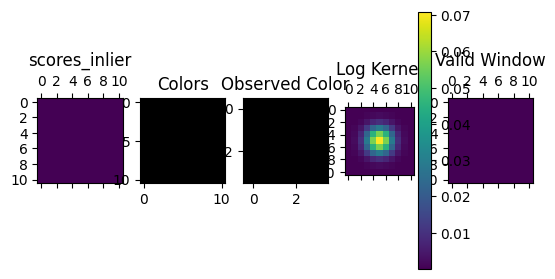

In [621]:
data = render(pose)
scores_image = jnp.zeros((renderer.height, renderer.width))
scores_image = scores_image.at[rows , cols ].set(data["score"])
b3d.rr_log_depth(scores_image, "scores")
b3d.rr_log_rgb(data["color_image"], "scores/rgb")
b3d.rr_log_rgb(observed_rgbd[...,:3], "scores/rgb_actual")
indices_image = jnp.zeros((renderer.height, renderer.width))
indices_image = indices_image.at[rows , cols ].set(jnp.arange(len(data["score"])))
b3d.rr_log_rgb(indices_image, "scores/indices")

print("Full score ", data["score"].sum())


IDX = 626
fig,ax = plt.subplots(1,5)
# plt.matshow(jnp.exp(data["log_kernel"][IDX]))
ax[0].matshow(data["scores_inlier"][IDX])
ax[0].set_title("scores_inlier")
ax[1].imshow(data["colors_window"][IDX])
ax[1].set_title("Colors")
print(data["colors_window"][IDX][filter_half_width, filter_half_width])
i,j = rows[IDX], cols[IDX]
print(i,j)
print("Score ", data["score"][IDX])
print("Score mixed ", data["score_mixed"][IDX])
print("scores_inlier ", data["scores_inlier"][IDX])
ax[2].imshow(jnp.ones((4,4,3)) * (observed_rgbd[i + filter_half_width,j + filter_half_width,:3]))
ax[2].set_title("Observed Color")
fig.colorbar(ax[3].matshow(jnp.exp(data["log_kernel"][IDX])))
ax[3].set_title("Log Kernel")
ax[4].matshow(data["valid_window"][IDX])
ax[4].set_title("Valid Window")
print(data["valid_window"][IDX])

In [620]:
pbar = tqdm(range(1000))
for _ in pbar:
    loss, grad_pose = value_and_grad_func(pose)
    pbar.set_description(f"Loss {loss}")
    pose = pose + grad_pose * 0.000001

Loss 416.986328125: 100%|██████████| 1000/1000 [00:03<00:00, 277.46it/s]    


In [528]:
pose

Pose(position=Array([-0.00085643, -0.00051613,  0.353866  ], dtype=float32), quaternion=Array([ 0.25555003,  0.70065314, -0.6084522 ,  0.27124184], dtype=float32))

[35 39]


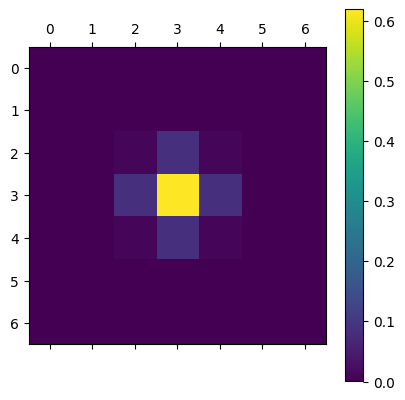

In [59]:
plt.matshow(jnp.exp(data["log_kernel"][10]))
print(indices[0])
plt.colorbar()

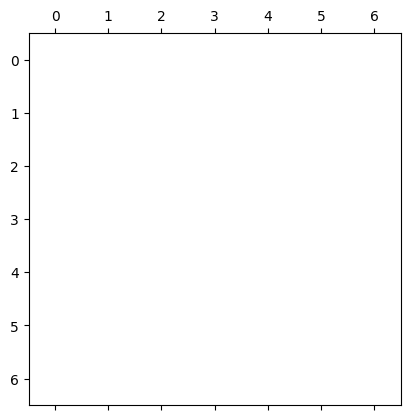

In [47]:
plt.matshow(data["log_kernel"][0])

In [ ]:
rgbd = renderer.render_rgbd_from_mesh(meshes[0].transform(Pose.from_position_and_target(jnp.array([0.25, 0.25, 0.0])).inv()))
